https://towardsdatascience.com/markov-chain-analysis-and-simulation-using-python-4507cee0b06e

In [335]:
from pymc3.gp.util import plot_gp_dist

In [759]:
def scaleX(x):
    return list(x/np.sum(x))

def rBeta(a,b):
    return np.random.beta(a,b)

def markovChain(state, P, M, N = 100):
    stateHist=state
    dfStateHist=pd.DataFrame(state)
    distr_hist = [[0,0,0]]
    for x in range(N):
        P = genTransMatrix()
        P_scale = np.multiply(P,M)
        state = np.dot(state,P_scale)
        stateHist=np.append(stateHist,state,axis=0)
        dfDistrHist = pd.DataFrame(stateHist)
        
    dfDistrHist.columns = ['Green', 'NFT', 'Burned']    
        
    return dfDistrHist   

def genTransMatrix():
    P = np.array([[rBeta(9,1), rBeta(1,19), rBeta(1,19)],
              [rBeta(1,19), rBeta(9,1), rBeta(1,19)],
              [0.01, 0, 0.99]])

    return np.array(list(map(scaleX, P)))   

Text(0, 0.5, 'Burned Token Supply')

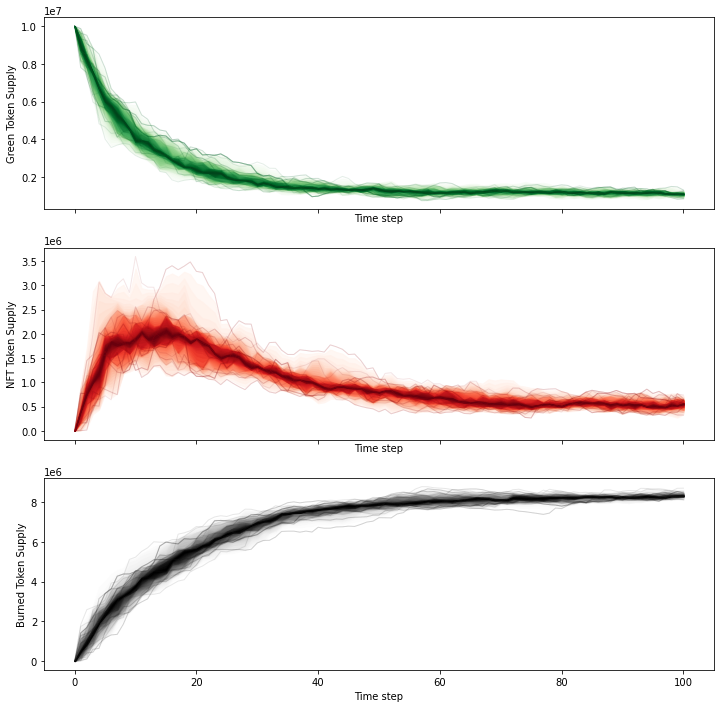

In [762]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

N = 100
M = np.repeat(1,9).reshape((3, 3)); M[1,0] = 1
state=np.array([[1e7, 0.0, 0.0]])

dfDistrHist = markovChain(state, genTransMatrix(), M, N)
green = dfDistrHist.Green.values.reshape(-1,1)
nft = dfDistrHist.NFT.values.reshape(-1,1)
burned = dfDistrHist.Burned.values.reshape(-1,1)

for k in range(1,25):
    dfDistrHist = markovChain(state, genTransMatrix(), M, N)
    green = np.hstack((green, dfDistrHist.Green.values.reshape(-1,1)))
    nft = np.hstack((nft, dfDistrHist.NFT.values.reshape(-1,1)))
    burned = np.hstack((burned, dfDistrHist.Burned.values.reshape(-1,1)))


fig, (green_ax, nft_ax, burned_ax) = plt.subplots(nrows=3, sharex=True, sharey=False, figsize=(12, 12))

plot_gp_dist(green_ax, green.transpose(), np.array(range(0,len(green))), palette="Greens")
green_ax.set_xlabel("Time step")
green_ax.set_ylabel("Green Token Supply")    

plot_gp_dist(nft_ax, nft.transpose(), np.array(range(0,len(green))), palette="Reds")
nft_ax.set_xlabel("Time step")
nft_ax.set_ylabel("NFT Token Supply")    

plot_gp_dist(burned_ax, burned.transpose(), np.array(range(0,len(green))), palette="Greys")
burned_ax.set_xlabel("Time step")
burned_ax.set_ylabel("Burned Token Supply")   


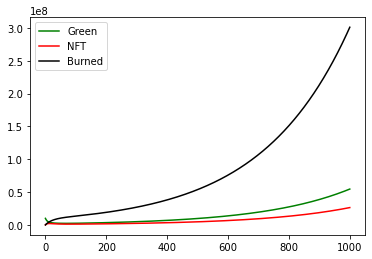

In [757]:
N = 1000
P = np.array([[0.9, 0.05, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, 0.99]])
dfDistrHist = markovChain(state, P, M, N)

ax = dfDistrHist.head(N).plot(color = ['green', 'red', 'black'])   

In [401]:
P = np.array([[0.9, 0.05, 0.05],
              [0.05, 0.9, 0.05],
              [0.01, 0, 0.99]])

A=np.append(np.transpose(P)-np.identity(3),[[1,1,1]],axis=0)
b=np.transpose(np.array([0,0,0,1]))
np.linalg.solve(np.transpose(A).dot(A), np.transpose(A).dot(b))

array([0.11111111, 0.05555556, 0.83333333])

[[0.48651349 0.41758242 0.0959041 ]]
[[0.20164609 0.70164609 0.09670782]
 [0.88277512 0.         0.11722488]
 [0.19791667 0.80208333 0.        ]]


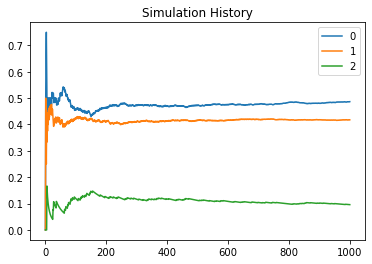

In [716]:
import numpy as np
import pandas as pd
from random import seed
from random import random
import matplotlib.pyplot as plt

P = np.array([[0.2, 0.7, 0.1],
              [0.9, 0.0, 0.1],
              [0.2, 0.8, 0.0]])



stateChangeHist= np.array([[0.0,  0.0,  0.0],
                          [0.0, 0.0,  0.0],
                          [0.0, 0.0,  0.0]])

state=np.array([[1.0, 0.0, 0.0]])
currentState=0
stateHist=state
dfStateHist=pd.DataFrame(state)
distr_hist = [[0,0,0]]
seed(4)
# Simulate from multinomial distribution
def simulate_multinomial(vmultinomial):
    r=np.random.uniform(0.0, 1.0)
    CS=np.cumsum(vmultinomial)
    CS=np.insert(CS,0,0)
    m=(np.where(CS<r))[0]
    nextState=m[len(m)-1]
    return nextState

for x in range(1000):
    currentRow=np.ma.masked_values((P[currentState]), 0.0)
    nextState=simulate_multinomial(currentRow)
    # Keep track of state changes
    stateChangeHist[currentState,nextState]+=1
    # Keep track of the state vector itself
    state=np.array([[0,0,0]])
    state[0,nextState]=1.0
    # Keep track of state history
    stateHist=np.append(stateHist,state,axis=0)
    currentState=nextState
    # calculate the actual distribution over the 3 states so far
    totals=np.sum(stateHist,axis=0)
    gt=np.sum(totals)
    distrib=totals/gt
    distrib=np.reshape(distrib,(1,3))
    distr_hist=np.append(distr_hist,distrib,axis=0)
                       
print(distrib)
P_hat=stateChangeHist/stateChangeHist.sum(axis=1)[:,None]
# Check estimated state transition probabilities based on history so far:
print(P_hat)
dfDistrHist = pd.DataFrame(distr_hist)
# Plot the distribution as the simulation progresses over time
dfDistrHist.plot(title="Simulation History")
plt.show()

In [714]:
vmultinomial = currentRow
r=np.random.uniform(0.0, 1.0)
CS=np.cumsum(vmultinomial)
CS=np.insert(CS,0,0)
m=(np.where(CS<r))[0]
nextState=m[len(m)-1]
CS

masked_array(data=[0.  , 0.01, 0.01, 1.  ],
             mask=False,
       fill_value=1e+20)

In [717]:
dfDistrHist.head(25)

,0,1,2
0,0.000000,0.000000,0.000000
1,0.500000,0.500000,0.000000
2,0.666667,0.333333,0.000000
3,0.750000,0.250000,0.000000
4,0.600000,0.400000,0.000000
5,0.500000,0.333333,0.166667
6,0.428571,0.428571,0.142857
7,0.500000,0.375000,0.125000
8,0.444444,0.444444,0.111111
9,0.500000,0.400000,0.100000
